# Entrenamiento y Servir en Modo Script con TensorFlow

El modo script es un formato de script de entrenamiento para TensorFlow que permite ejecutar cualquier script de entrenamiento de TensorFlow en SageMaker con modificaciones mínimas. El SDK de Python de SageMaker se encarga de transferir tu script a una instancia de entrenamiento en SageMaker. En la instancia de entrenamiento, el soporte nativo de TensorFlow de SageMaker configura las variables de entorno relacionadas con el entrenamiento y ejecuta tu script de entrenamiento. En esta sesión, utilizamos el SDK de Python de SageMaker para iniciar un trabajo de entrenamiento y desplegar el modelo entrenado.

El modo script admite el entrenamiento con un script de Python, un módulo de Python o un script de shell. En este ejemplo, utilizamos un script de Python para entrenar un modelo de clasificación en el conjunto de datos MNIST. En este ejemplo, mostraremos lo fácil que es entrenar en SageMaker usando scripts de TensorFlow 2.0 con el SDK de Python de SageMaker.

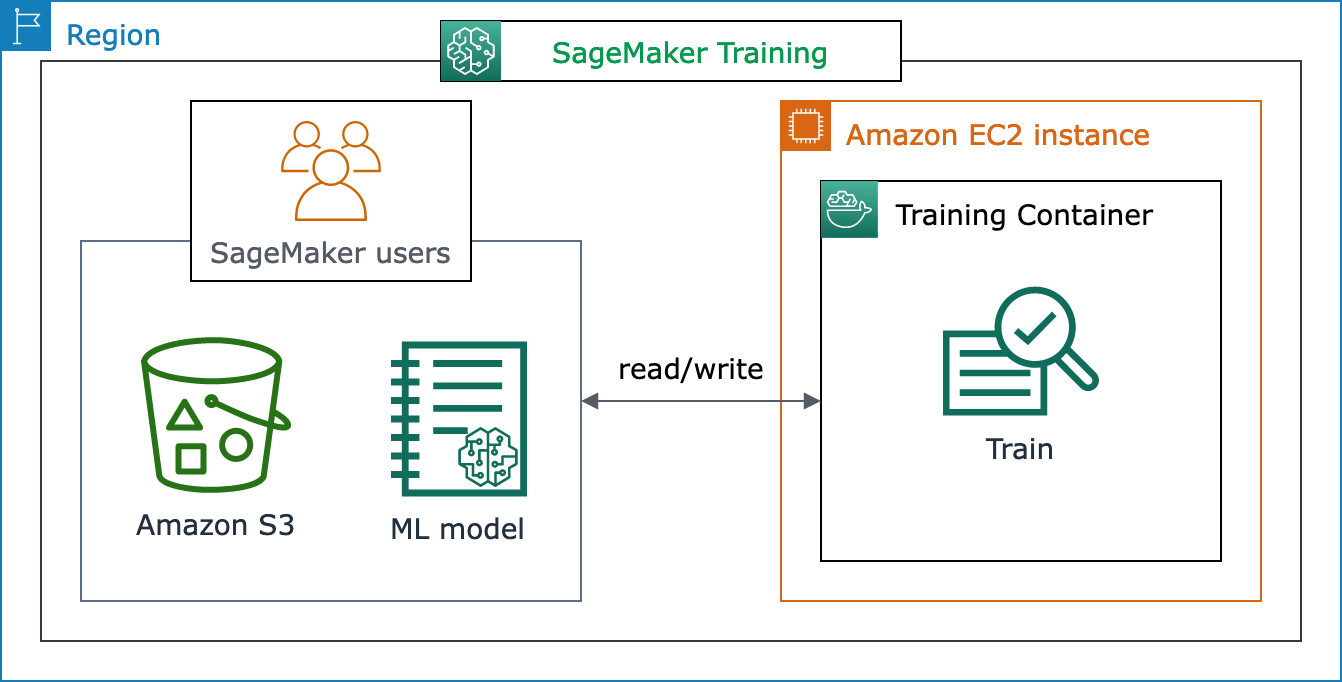

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
region

'us-east-1'

In [3]:
role

'arn:aws:iam::221082178761:role/service-role/AmazonSageMaker-ExecutionRole-20250330T132053'

### Training Data

AWS tiene bucket donde podemos encontrar dataset entre ellos MSNIST. 

 * sagemaker-sample-data-<REGION> under the prefix tensorflow/mnist

In [4]:
training_data_uri = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)

In [5]:
training_data_uri

's3://sagemaker-sample-data-us-east-1/tensorflow/mnist'

In [6]:
!aws s3 ls $training_data_uri/

2019-01-24 23:36:40   31360128 eval_data.npy
2019-01-24 23:36:40      40128 eval_labels.npy
2019-01-24 23:36:40  172480128 train_data.npy
2019-01-24 23:36:40     220128 train_labels.npy


# Construcción de un Script para Entrenamiento Distribuido

El script de entrenamiento de este tutorial fue adaptado del ejemplo oficial de CNN MNIST de TensorFlow. Lo hemos modificado para manejar el parámetro `model_dir` que pasa SageMaker. Este es un camino en S3 que puede usarse para compartir datos durante el entrenamiento distribuido y para almacenar checkpoints o persistir el modelo. También hemos agregado una función para el análisis de argumentos con el fin de manejar las variables relacionadas con el entrenamiento.

Al final del trabajo de entrenamiento, hemos añadido un paso para exportar el modelo entrenado a la ruta almacenada en la variable de entorno `SM_MODEL_DIR`, que siempre apunta a `/opt/ml/model`. Esto es crítico porque SageMaker sube todos los artefactos del modelo en esta carpeta a S3 al finalizar el entrenamiento.


In [8]:
!wget https://raw.githubusercontent.com/CamilaCortex/MLOps-AWS/refs/heads/main/Custom_Models/custom_with_tensor_flow/mnist-tf2.py --no-check-certificate

--2025-03-30 21:03:56--  https://raw.githubusercontent.com/CamilaCortex/MLOps-AWS/refs/heads/main/Custom_Models/custom_with_tensor_flow/mnist-tf2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
  Unable to locally verify the issuer's authority.
200 OKequest sent, awaiting response... 
Length: 2307 (2.3K) [text/plain]
Saving to: ‘mnist-tf2.py’

mnist-tf2.py        100%[===================>]   2.25K  --.-KB/s    in 0s      

2025-03-30 21:03:56 (51.1 MB/s) - ‘mnist-tf2.py’ saved [2307/2307]



In [9]:
# TensorFlow 2.x script
!pygmentize 'mnist-tf2.py'

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train)
    model.evaluate(x_test, y_test)

    return model


def _load_training_data(base_dir):
    """Load MNIST training data"""
    x_train = np.load(os.path.join(base_dir, 'train_data.npy'))
    y_train = np.load(os.path.join(base_dir, 'train_labels.npy'))
    return x_train, y_train


def _load_testing_data(base_dir):
    """Load MNIST testing data"""
    x_test = np.load(os.path.join(base_dir, 'eval_data.npy'))
    y_test = np

________
# Creación de un Trabajo de Entrenamiento Usando el Estimador de TensorFlow en SageMaker

Amazon SageMaker facilita la tarea de entrenar modelos de aprendizaje automático mediante el uso de estimadores. En este caso, utilizaremos el estimador `sagemaker.tensorflow.TensorFlow` para gestionar aspectos importantes como localizar el contenedor del modo script, cargar tu script a una ubicación en S3 y crear un trabajo de entrenamiento en SageMaker.

## Pasos para Crear un Trabajo de Entrenamiento

### 1. Elige el Python y el Modo Script

- **Versión de Python**: La propiedad `py_version` se establece en `'py3'` para indicar que utilizamos el modo script, ya que el modo legacy solo admite Python 2. Aunque Python 2 está en proceso de deprecación, aún puedes usarlo en el modo script configurando `py_version` a `'py2'` y `script_mode` a `True`.

### 2. Configuración para Entrenamiento Distribuido

- **Distribución**: Si deseas configurar un entrenamiento distribuido (ya sea en un clúster de instancias o en múltiples GPUs), utiliza el parámetro `distribution`. En este ejemplo, empleamos servidores de parámetros como el esquema para el entrenamiento distribuido. Los trabajos de entrenamiento en SageMaker se ejecutan en clústeres homogéneos. Para optimizar el rendimiento, ejecutamos un servidor de parámetros en cada instancia del clúster, eliminando la necesidad de especificar cuántos servidores se requerirán. SageMaker también admite entrenamiento distribuido con Horovod. [Consulta la documentación completa](https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-training.html) para configuraciones de distribuciones.

### 3. Selección del Tipo de Instancia

- **Tipo de Instancia**: Elige la instancia EC2 basada en el tamaño de tus datos, algoritmo y tareas. En el ejemplo, hemos seleccionado `ml.c5.xlarge`. También puedes considerar las instancias G4dn, que cuentan con GPUs NVIDIA T4 y CPUs Intel Cascade Lake, optimizadas para inferencia en machine learning y entrenamientos a pequeña escala. [Consulta más información sobre tipos de instancias y precios](https://aws.amazon.com/ec2/instance-types/).

### 4. Uso de Instancias Spot para Optimización de Costos

- **Instancias Spot (Opcional)**: Para reducir costos, puedes aprovechar las instancias Spot de Amazon EC2 estableciendo este parámetro en `True`. El entrenamiento en instancias Spot puede reducir el costo de entrenamiento en hasta un 90% en comparación con instancias bajo demanda. SageMaker gestiona las interrupciones de Spot por ti. Especifica cuáles trabajos de entrenamiento usarán instancias Spot y establece una condición de parada que determine cuánto tiempo esperará SageMaker para usar las instancias Spot. [Consulta la documentación completa aquí](https://docs.aws.amazon.com/sagemaker/latest/dg/model-ver-spot.html).

### 5. Usar TensorFlow 2.1

También puedes iniciar un estimador para entrenar con un script de TensorFlow 2.1. Solo necesitarás cambiar el nombre del script y la `framework_version`.

Este enfoque simplifica la implementación y escalado de tus modelos de aprendizaje automático, permitiéndote concentrarte en el desarrollo del modelo en lugar de la infraestructura subyacente.

In [10]:
from sagemaker.tensorflow import TensorFlow


mnist_estimator = TensorFlow(entry_point='mnist-tf2.py',
                             role=role,
                             instance_count=2,
                             instance_type='ml.m5.large',
                             framework_version='2.1.0',
                             py_version='py3',
                             distribution={'parameter_server': {'enabled': True}})

## ¿Qué hace el estimador exactamente?
El estimador TensorFlow en SageMaker gestiona varios aspectos:

* Configuración del Entorno de Ejecución: Automáticamente configura el contenedor necesario para ejecutar TensorFlow en el entorno de SageMaker, asegurando que se tengan las versiones adecuadas de TensorFlow y Python.

* Preparación del Script: Sube el script mnist-tf2.py y cualquier otro archivo necesario a un bucket de S3 para poder ser accedidos durante el entrenamiento.

* Distribución del Entrenamiento: Cuando se especifica un entrenamiento distribuido (como con el uso del parameter_server), el estimador gestiona cómo distribuir las tareas y los roles de cada instancia en el clúster.

* Interacción con S3: Se ocupa de cargar datos de entrenamiento desde S3 y guardar los resultados del entrenamiento y modelos en S3.

* Iniciar el Trabajo de Entrenamiento: Una vez configurado, inicia el trabajo de entrenamiento en el clúster de instancias seleccionadas en SageMaker.

En resumen, el estimador sirve como una abstracción que gestiona la configuración del entorno y facilita el proceso de entrenamiento en la nube, lo que permite a los usuarios concentrarse más en la estructura del modelo y los datos de entrada.

_____

# Llamada a fit para Iniciar un Trabajo de Entrenamiento

Para comenzar un trabajo de entrenamiento en Amazon SageMaker, utilizamos el método `fit()` del estimador con `estimator.fit(training_data_uri)`.

## Detalles de la Llamada a fit

- **Ubicación en S3**: Utilizamos una ubicación en Amazon S3 como entrada para los datos de entrenamiento. Cuando llamamos a `fit`, se crea un canal por defecto llamado 'training', que apunta a esta ubicación en S3. En el script de entrenamiento, podemos acceder a los datos desde la ruta almacenada en `SM_CHANNEL_TRAINING`.

- **Tipos de Entrada**: Aunque aquí usamos una ubicación en S3, `fit` puede aceptar otros tipos de entrada. [Consulta la documentación de la API para más detalles](https://sagemaker.readthedocs.io/en/stable/index.html).

## Ejecución del Script de Entrenamiento

Cuando el entrenamiento comienza, el contenedor de TensorFlow ejecuta el script `mnist-tf2.py`. Este script recibe los hiperparámetros y `model_dir` como argumentos del script, pasados desde el estimador. En este ejemplo específico, no definimos hiperparámetros, por lo que no se pasan, y el `model_dir` tiene como valor predeterminado `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>`. Por lo tanto, la ejecución del script sería así:

```bash
python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>

In [11]:
mnist_estimator.fit(training_data_uri)

[03/30/25 21:08:56] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=190438;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=341674;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=627689;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=748592;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[03/30/25 21:08:57] INFO     Amazon SageMaker Debugger does not currently support Parameter Server ]8;id=747983;file:///opt/conda/lib/python3.11/site-packages/sagemaker/tensorflow/estimator.py\estimator.py]8;;\:]8;id=114708;file:///opt/conda/lib/python3.11/site-packages/sagemaker/tensorflow/estimator.py#427\427]8;;\
                             distribution                                                                          

                    INFO     Amazon SageMaker Debugger does not currently support Parameter Server ]8;id=493548;file:///opt/conda/lib/python3.11/site-packages/sagemaker/tensorflow/estimator.py\estimator.py]8;;\:]8;id=844295;file:///opt/conda/lib/python3.11/site-packages/sagemaker/tensorflow/estimator.py#427\427]8;;\
                             distribution                                                                          

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=735252;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=154282;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=4083;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=912100;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             tensorflow-training-2025-03-30-21-08-56-846                                           

2025-03-30 21:08:59 Starting - Starting the training job...
..25-03-30 21:09:14 Starting - Preparing the instances for training.
..25-03-30 21:09:36 Downloading - Downloading input data.
.2025-03-30 21:10:40,374 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2025-03-30 21:10:40,383 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2025-03-30 21:10:43,658 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2025-03-30 21:10:43,667 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2025-03-30 21:10:43,773 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2025-03-30 21:10:43,774 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2025-03-30 21:10:43,774 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2025-03-30 21:10:4

________

# Desplegar el Modelo Entrenado a un Endpoint

Después de entrenar un modelo en SageMaker, el siguiente paso es desplegarlo para que pueda hacer predicciones en tiempo real. Para ello, utilizamos el método `deploy()`.

## Proceso de Despliegue del Modelo

- **Creación del Modelo en SageMaker**: El método `deploy()` crea un modelo en SageMaker que se despliega en un endpoint. Este endpoint puede entonces gestionar solicitudes en tiempo real para realizar predicciones.

- **Uso del Contenedor TensorFlow Serving**: Dado que entrenamos nuestro modelo en modo script, utilizaremos el contenedor TensorFlow Serving para este endpoint. Este contenedor ejecuta una implementación de un servidor web compatible con el protocolo de hosting de SageMaker.

## Funcionamiento del Contenedor de Inferencia

SageMaker ofrece un marco que permite a los usuarios personalizar el código de inferencia en contenedores. Para más información sobre cómo SageMaker ejecuta los contenedores de inferencia, consulta el documento [Usando tu propio código de inferencia](https://docs.aws.amazon.com/sagemaker/latest/dg/your-own-inference-code.html).

Al desplegar el modelo, automáticamente se maneja la escalabilidad, seguridad y monitoreo del endpoint, permitiéndonos enfocarnos en atender solicitudes de predicción de manera efectiva.

In [12]:
# cell 08
predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

[03/30/25 21:15:57] INFO     image_uri is not presented, retrieving image_uri based on instance_type,  ]8;id=93124;file:///opt/conda/lib/python3.11/site-packages/sagemaker/tensorflow/model.py\model.py]8;;\:]8;id=233381;file:///opt/conda/lib/python3.11/site-packages/sagemaker/tensorflow/model.py#508\508]8;;\
                             framework etc.                                                                        

[03/30/25 21:15:58] INFO     Creating model with name: tensorflow-training-2025-03-30-21-15-57-795  ]8;id=593982;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=515749;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/30/25 21:15:59] INFO     Creating endpoint-config with name                                     ]8;id=844608;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=837302;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             tensorflow-training-2025-03-30-21-15-57-795                                           

                    INFO     Creating endpoint with name                                            ]8;id=458100;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=991038;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\
                             tensorflow-training-2025-03-30-21-15-57-795                                           

----!

### ¿Qué acabamos de hacer? 


Creación del Endpoint: Al llamar a deploy, SageMaker crea un endpoint en el cuál se ejecuta el modelo entrenado dentro de un contenedor apropiado. Este endpoint es una API REST donde puedes enviar solicitudes HTTP para obtener predicciones.

* predictor: La variable predictor es un objeto de SageMaker que proporciona métodos para interactuar con el endpoint. A través de este objeto, puedes enviar datos para predecir y recibir las respuestas (predicciones) del modelo.

### Usos Típicos:
* Predicciones en Tiempo Real: Una vez desplegado, puedes usar el predictor para enviar datos al modelo y obtener predicciones, lo cual es útil para aplicaciones interactivas o en las que necesitas respuestas rápidas.

* Escalabilidad: Esta configuración permite ajustar el número y tipo de instancias en respuesta a la carga, asegurando que el servicio de predicciones se mantenga rápido y confiable.

In [14]:
import numpy as np

!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_data.npy train_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/train_labels.npy train_labels.npy


download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/train_data.npy to ./train_data.npy
download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/train_labels.npy to ./train_labels.npy


In [15]:
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')

## Formatos de Entrada y Salida en Endpoints de SageMaker con TensorFlow Serving

Los formatos de los datos de entrada y salida para los endpoints en SageMaker que utilizan TensorFlow Serving corresponden directamente a los formatos de solicitud y respuesta del método `Predict` en la API REST de TensorFlow Serving. Sin embargo, los endpoints de TensorFlow Serving de SageMaker también pueden aceptar formatos de entrada adicionales que no son parte de la API REST de TensorFlow, incluyendo:

- Formato JSON simplificado
- Objetos JSON delimitados por líneas ("jsons" o "jsonlines")
- Datos en formato CSV

## Ejemplo de Uso con un Array de NumPy

En este ejemplo, utilizamos un array de NumPy como entrada. Este será serializado automáticamente en el formato JSON simplificado. Esto es conveniente, ya que permite a los usuarios trabajar con estructuras de datos familiares en Python, como NumPy, y dejar que SageMaker gestione la serialización adecuada.

Además, TensorFlow Serving puede procesar múltiples elementos a la vez, lo que significa que puedes enviar un lote de datos para predecir en una sola solicitud, mejorando la eficiencia al reducir el número de llamadas a la API.

Puedes encontrar la documentación completa sobre cómo realizar predicciones contra un endpoint de SageMaker que utiliza TensorFlow Serving [aquí](https://docs.aws.amazon.com/sagemaker/latest/dg/tf-serving.html).

### Ventajas de Estos Formatos de Entrada:

- **Flexibilidad**: Permite una mayor variedad de formatos de entrada, facilitando la integración con diferentes tipos de datos de producción sin necesidad de pasos intermedios de transformación complicados.
  
- **Eficiencia**: Al poder procesar múltiples elementos a la vez, los endpoints son capaces de manejar grandes volúmenes de datos de una manera eficiente, reduciendo la latencia general de cada predicción.

Estos atributos hacen que los endpoints de SageMaker con TensorFlow Serving sean muy versátiles y adecuados para una amplia variedad de aplicaciones de machine learning en tiempo real.

In [20]:
train_data[0].shape

(784,)

In [21]:
train_data.shape

(55000, 784)

In [17]:
predictions = predictor.predict(train_data[:50])
for i in range(0, 50):
    prediction = np.argmax(predictions['predictions'][i])
    label = train_labels[i]
    print('prediction is {}, label is {}, matched: {}'.format(prediction, label, prediction == label))

prediction is 7, label is 7, matched: True
prediction is 3, label is 3, matched: True
prediction is 4, label is 4, matched: True
prediction is 6, label is 6, matched: True
prediction is 1, label is 1, matched: True
prediction is 8, label is 8, matched: True
prediction is 1, label is 1, matched: True
prediction is 0, label is 0, matched: True
prediction is 9, label is 9, matched: True
prediction is 8, label is 8, matched: True
prediction is 0, label is 0, matched: True
prediction is 3, label is 3, matched: True
prediction is 1, label is 1, matched: True
prediction is 2, label is 2, matched: True
prediction is 7, label is 7, matched: True
prediction is 0, label is 0, matched: True
prediction is 2, label is 2, matched: True
prediction is 9, label is 9, matched: True
prediction is 6, label is 6, matched: True
prediction is 0, label is 0, matched: True
prediction is 1, label is 1, matched: True
prediction is 6, label is 6, matched: True
prediction is 7, label is 7, matched: True
prediction 

In [18]:
np.argmax(predictions['predictions'][0])

7

# Balanceador de Carga y Escalado Automático en Endpoints de SageMaker

## Balanceador de Carga

Un **balanceador de carga** es un componente crítico en los endpoints de inferencia de SageMaker. Su función es distribuir el tráfico de solicitudes entrantes entre múltiples instancias backend de manera equitativa. Esto garantiza:

- **Distribución del Tráfico**: El balanceador de carga administra y distribuye automáticamente el tráfico entre las instancias disponibles, evitando que alguna instancia se sobrecargue.
- **Alta Disponibilidad**: Al permitir que múltiples instancias manejen las solicitudes, el balanceador de carga mejora la disponibilidad y la resiliencia del servicio. Si una instancia falla, las solicitudes se redirigen a las instancias operativas restantes.

## Escalado Automático

El **escalado automático** permite ajustar dinámicamente el número de instancias que sirven a un endpoint basado en la demanda actual. Sus beneficios y configuraciones clave incluyen:

- **Políticas de Escalado**: Define las condiciones bajo las cuales el número de instancias debe aumentar o disminuir. Estas condiciones suelen basarse en métricas como el uso de CPU, la latencia de respuesta o el número de solicitudes por segundo.

- **Escalado Horizontal**:
  - **Aumento de Instancias**: Incrementa el número de instancias cuando la carga de trabajo es alta, asegurando que el tiempo de respuesta se mantenga bajo y eficiente.
  - **Reducción de Instancias**: Disminuye el número de instancias cuando la carga de trabajo disminuye, optimizando los costos.

- **Implementación del Escalado Automático**:
  - **Configuración**: Se realiza al crear o modificar un endpoint en SageMaker, especificando las reglas de escalado.
  - **AWS Application Auto Scaling**: SageMaker utiliza este servicio para implementar el auto scaling, administrando automáticamente las instancias según las políticas definidas.

Al combinar balanceadores de carga con escalado automático en Amazon SageMaker, se logra un sistema de inferencia robusto, escalable y eficiente en costos que responde adecuadamente a cambios en la demanda de predicciones.

In [22]:
predictor.delete_endpoint()

[03/30/25 21:28:56] INFO     Deleting endpoint configuration with name:                             ]8;id=238003;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=8116;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4865\4865]8;;\
                             tensorflow-training-2025-03-30-21-15-57-795                                           

                    INFO     Deleting endpoint with name:                                           ]8;id=11533;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=506469;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4855\4855]8;;\
                             tensorflow-training-2025-03-30-21-15-57-795                                           